# Basic Bioinformatics
## Sequence, Alignment, and Phylogeny
Here we will use the simple IL6 dataset to show basic skbio functionality.

## Basic sequence types

scikit-bio supports the three basic sequence types of biology: DNA, RNA, and Protein. The primary information stored for each type of sequence object is the underlying sequence data itself which is stored as an immutable NumPy array. Additionally, each type of sequence may include optional metadata and positional metadata, which are each mutable.

In [1]:
from collections import defaultdict
import functools

In [2]:
import numpy as np

In [3]:
from skbio.sequence import Protein, DNA
from skbio.sequence.distance import kmer_distance, hamming
from skbio.alignment import TabularMSA, global_pairwise_align_protein, local_pairwise_align_ssw
from skbio.stats.distance import DistanceMatrix
from skbio.tree import TreeNode, nj
from scipy.cluster.hierarchy import average

In [52]:
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
human_il6 = ('ATTCTGCCCTCGAGCCCACCGGGAACGAAAGAGAAGCTCTATCTCCCCTCCAGGAGCCCAGCTATGAACTCCTTCTCCACAAGCGCCTTCGGTCCAGTTGCCTTCTCCCTGGGGCTGCTCCTGGTGTTGCCTGCTGCCTTCCCTGCCCCAGTACCCCCAGGAGAAGATTCCAAAGATGTAGCCGCCCCACACAGACAGCCACTCACCTCTTCAGAACGAATTGACAAACAAATTCGGTACATCCTCGACGGCATCTCAGCCCTGAGAAAGGAGACATGTAACAAGAGTAACATGTGTGAAAGCAGCAAAGAGGCACTGGCAGAAAACAACCTGAACCTTCCAAAGATGGCTGAAAAAGATGGATGCTTCCAATCTGGATTCAATGAGGAGACTTGCCTGGTGAAAATCATCACTGGTCTTTTGGAGTTTGAGGTATACCTAGAGTACCTCCAGAACAGATTTGAGAGTAGTGAGGAACAAGCCAGAGCTGTGCAGATGAGTACAAAAGTCCTGATCCAGTTCCTGCAGAAAAAGGCAAAGAATCTAGATGCAATAACCACCCCTGACCCAACCACAAATGCCAGCCTGCTGACGAAGCTGCAGGCACAGAACCAGTGGCTGCAGGACATGACAACTCATCTCATTCTGCGCAGCTTTAAGGAGTTCCTGCAGTCCAGCCTGAGGGCTCTTCGGCAAATGTAGCATGGGCACCTCAGATTGTTGTTGTTAATGGGCATTCCTTCTTCTGGTCAGAAACCTGTCCACTGGGCACAGAACTTATGTTGTTCTCTATGGAGAACTAAAAGTATGAGCGTTAGGACACTATTTTAATTATTTTTAATTTATTAATATTTAAATATGTGAAGCTGAGTTAATTTATGTAAGTCATATTTATATTTTTAAGAAGTACCACTTGAAACATTTTATGTATTAGTTTTGAAATAATAATGGAAAGTGGCTATGCAGTTTGAATATCCTTTGTTTCAGAGCCAGATCATTTCTTGGAAAGTGTAGGCTTACCTCAAATAAATGGCTAACTTATACATATTTTTAAAGAAATATTTATATTGTATTTATATAATGTATAAATGGTTTTTATACCAATAAATGGCATTTTAAAAAATTCA')

In [6]:
chimp_il6 = ('AAGATGCCACAAGGTCCTCCTTTGACATCCCCAACAAAGAGGACTGGAGATGTCTGAGGCTCATTCTGCCCTCGAGCCCACCGGGAACGAAAGAGAAGCTCTATCTCCCCTCCAGGAGCCCAGCTATGAACTCCGTCTCCACAAGTAAGTGCAGGAAATCCTTAGCCCTGGAACTGCCAGCGGCGGTCGAGCCCTGTGTGAGGGAGGGGTGTGTGGCCCAGGGAGGGCTGGCGGGCGGCCAGCAGCAGAGGCAGGCTCCCAGCTGTGCTGTCAGCTCACCCCTGCGCTCGCTCCCCTCCGGCACAGGCGCCTTCGGTCCAGTTGCCTTCTCCCTGGGGCTGCTCCTGGTGTTGCCTGCTGCCTTCCCTGCCCCAGTACCCCCAGGAGAAGATTCCAAAGATGTAGCCGCCCCACACAGACAGCCACTCACCTCTTCAGAACGAATTGACAAACAAATTCGGTACATCCTCGACGGCATCTCAGCCCTGAGAAAGGAGACATGTAACAAGAGTAACATGTGTGAAAGCAGCAAAGAGGCACTGGCAGAAAACAACCTGAACCTTCCAAAGATGGCTGAAAAAGATGGATGCTTCCAATCTGGATTCAATGAGGAGACTTGCCTGGTGAAAATCATCACTGGTCTTTTGGAGTTTGAGGTATACCTAGAGTACCTCCAGAACAGATTTGAGAGTAGTGAGGAACAAGCCAGAGCTGTGCAGATGAGTACAAAAGTCCTGATCCAGTTCCTGCAGAAAAAGGTGGGTGTGTCCTCATTCCCTCAACTTGGTGTGGGGGAAGACAGGCTCAAAGACAGTGTCCTGGACAACTCAGGGATGCAATGCCACTTCCAAAAGAGAAGGCTACAAGTAAACAAAAGAGTCTGAGAAATAGTTTCTGATTGTTATTGTTAAATCTTTTTTTGTTTGTTTGGTCGGTTGGCTCTCTTCTGCAAAGGACATCAATAACTGTATTTTAAACTATATATTAACTGAGGTAGATTTTAACATCAATTTTTAATAGTGCAAGAGATTTAAAAACAAAAGGGGGGGGGGGGGCAGAAAAAAGTGCATCCAACTCCAGCCAGTGATCCACAGAAACAAAGACCAAGGAGCACAAAATGATTTTAAGATTTTAGTCATTGCCAAGTGACATTCTTCTCATTGTGGTTGTTTCAATTCTTTTTCCTACCTTTTACCAGAGAGTTAGTTCAGAGAAATGGTCAGAGACTCAAGGGTGGAAAGAGGTACCAAAGGCTTTGGCCACCAGTAGCTGGCTATTCAGACAGCAGGGAGTAAAGACTTGCTGGCTAGCATGTGGAGGAGCCAAAGTTCAATAAGAAGGGGCCTAGAATGAAACCCTTGGTGCTGATCCTGCCTCTGCCATTTCTACTTAAGCCAGGGTTTCTCATATGTTAACATGCATGGGAATTCCCCGGGCATCTTCTTGTGGTGTGGAGTCTGACTTAGCAAGCCTCGGGTGGGTTTGAGGGTCAAATTTCTACCAGGCTTATATCCCTGGTGATGCTGCAGAATTCCAGGACCACACTTGGAGGTTTAAGGCCTTCCACAAGTTACTTATCCCATATGGTGGGTCTATGGAAAGGTGTTTCCCAGTCCTCTTTACACCACCGGATCAGTGGTCTTTCAACAGATCCTAAAGGGATGGTGAGAGGGAAACTGGAGAAAAGTATTAGATTTAGAGGCCACTGAAGAACCCATATTAAAATGCCTTTAAGTATGGGCTCTTCATTCATATACTAAATATGAACTATGTGCCAGGCATTATTTCATATGACAGAATACAAACAAATAAGATAGTGATGCTGGTCAGGCTTGGTGGCTCATGCCTGTATTCCCTAAACTTTGGGAGCCTAAGGTGAGAACTCCTTGAACTCCTAAGGCCAGGAGTTCAAGACGAGCCTGGATAACACAGCAAGACCCCATCTCTACAAAAAACCAAAACCAAACAAACAAAAATGATAGTGGTGCTTCCCTCAGGATGCTTGTGGTCTAATGGGAGACAGAACAGCAAAGGGATGATTAGAAGTTGGTTGCTGTGAGCCAGGCACAGTGCTGATATAATCCCAGCACTTTGGGAGGCTGAGGTGGGTGGATCATTTGAGGCCAGGAGTTTAAGACCAGCCTGGTCAACATGGTAAAACCCCATCT')

In [7]:
monkey_il6 = ('GCTTTACTCTGTCAAGACATGCCAAAGTGCTGAGTCACTAATAAAAGAAAAAAAGAAAGTAAAGGAAGAGTGATTCTGCTTCTTAGCGCTAGCCTCAGTGACGACCTAAGCTGCACTTTTCCCCCTAGTTGAGTCTTGCGATGCTAAAGGACGTCACATTGCACAATCTTAATGTTTCCAATCAGCCCCACCCGCTCTGGCCCCACCCTAACCCTCCAACAAAGATTTATCAAATGTGGGATTTTCCCATGAGTCTCAATATTAGAGTCTCAACCCCCAATAAATATGAGACTGGAGATGTCTGAGGCTCATTCTGCCCTCGAGCCCACCAGGAACGAAAGAGAAGCTCTATCTGCCCTCCAGGAACCCAGATATGAACTCCGTCTCCACAAGTAAGTGCAGGAAATCCCTAGCCCTGGAACGGCCAGCGGCGGTCGAGCCCTGTGTGAGGGAGGGGTGTGTGGCCCAGGGAGGGCTGGCGGGCGGCCAGCAGCAGAGGCAGGCTCCCAGCTGTGCTGTCAGCTCACCCCGCCGCTCGCTCCCCTCCGGCACAGGCGCCTTCGGTCCAGTTGCCTTCTCCCTGGGGCTGCTCCTGGTGTTGCCTGCTGCCTTCCCCGCCCCAGTACTCCCAGGAGAAGATTCCAAAGATGTAGCCGCCCCACACAGCCAGCCACTGACCTCTTCAGAACGAATTGACAAACACATTCGGTACATCCTCGACGGCATCTCAGCCCTGAGAAAGGAGACATGTAACAGGAGTAACATGTGTGAAAGCAGCAAAGAGGCACTGGCAGAAAACAACCTGAACCTTCCAAAGATGGCTGAAAAAGATGGATGCTTCCAATCTGGATTCAATGAGGACACTTGCCTGGTGAAAATCATCACTGGTCTTTTGGAGTTTGAGGTATACCTAGAGTACCTCCAGAACAGGTTTGAGAGTAGTGAGGAGCAAGCCAGAGCTGTGCAAATGAGTACAAAAGTCCTGATCCAGTTCCTGCAGAAAAAGGTGGGTGTGTCCTCCTTCCTTCACCTTGGTGTGGGAGAAGACAGGCTCAAAGACAGTGTCCTGGACAACTCAGGGATGCAATGCCACTTCCAAAAGAGAAGGCTACATGTAAACAAAAAAGTCTGAGAAATAGTTTCTGATAGTTACCGTTAAATCTTTTTTTGTTTGGTTGGCTCTCTTCTGCAAAGGACATCAATAACTGTACTTTAAACTATATTAACTGAGGTGGATTTTAACATCAATTTTTAATAGTGCAAGAGATTAAAAAAAAAAGGGGGGGGTCAGAAAGAAGTACATCCATCCCCACCCAGTGATCCACAGAAACAAAAACCAAGGGGCATAAAATGATTTTAAGATTTTAGTTATTGTCAAGTGGCATTCTTCTCATTGTAGTTGTTTCAACTCTTTTTCCTACCTTTTACCAGAGAGTTAGTTCAGAGAAACGGTCAGAGACTCAAGGCTGGAAAGAGGTACCAAGGGCTTTGGCCACCAGTAGCTGGCTATTCAAACAGCAGGGAGTAAAGAGTTGCTGGCTAGCATGTGGAGGAGCCAAAGCTCAATAAGTAGGGGCCTAGAAGGAAACCCTTGGTGCTGATCCTGCCTCTGCCATTTCTACTTGTTCGCCGTAAGCCAGGGTTTCTCCTATGTGAATGTGCATGGGAATTCCCTGGGCATCTTGCTGTGGTGTAGAGTCTGACTTGGCAGGCCTTGGGTGGGTTTGAGGGTCATATTTCTAGCAGGCTTATATCCCTGGTGATGCTGCAGAATTCCAGGACCACACTTGGAGGTTTAAGGCCTTCCACAAGTTACTTATCCCATCTGGTGGGTCTATGGAAAGATGTTTCCCAGTCCTCTTTACACCACCAGATCACTGGTCTTTCGACAGATCCTAAAGGGATGGTGAGAGGGAAACTGGAGAAAAGTACTAGATTTAGAGGCCACTGAAGAACTCATATTAAAATGCCTTTAAGTATGGGTTCTTCATTCATATACTAAATATGAACTATGTGCCAGGCATTATTTCATATGACAGAATACAAACAAATAAGATAGTGATGCTGGTCAGGCTTGGTGGTTCATGCCTGTATTCCCTAAACTTTGGGAGCCTAAGGTGAGAACTCCTTGAACTCCTAAGGCCAGGAGTTCAAGACCAGCCTGGACAACATAGCGAGACCCCATTGCTACAAAAACACAAAACCAAACAAACAAAAAGATAGTGGTGCTTCCCTCAGGATGTTTGTGGTCTAATGGGAGACAGAACAGCAAAGGGATGATTAGAAGTTAGTTGCTGCGAGCCAGGCACAGTGCTGATATAATCCCAGCACTTTGGGAGGCTGAGGTGGGTGGATCACTTGAGG')

In [8]:
pig_il6 = ('CAGTCTGCCCTCGAGCCCACCAGGAACGAAAGAGAGCTCCATCTGCCCTCCAGGAACCCAGCTATGAACTCCCTCTCCACAAGCGCCTTCAGTCCAGTCGCCTTCTCCCTGGGGCTGCTTCTGGTGATGGCTACTGCCTTCCCTACCCCGGGACGCCTGGAAGAAGATGCCAAAGGTGATGCCACCTCAGACAAAATGCTCTTCACCTCTCCGGACAAAACTGAAGAACTCATTAAGTACATCCTCGGCAAAATCTCTGCAATGAGAAAGGAGATGTGTGAGAAGTATGAGAAGTGTGAAAACAGCAAGGAGGTACTGGCAGAAAACAACCTGAACCTTCCAAAAATGGCAGAAAAAGACGGATGCTTCCAATCTGGGTTCAATCAGGAGACCTGCTTGATGAGAATCACCACCGGTCTTGTGGAGTTTCAGATATACCTGGACTACCTCCAGAAAGAGTATGAGAGCAATAAGGGAAATGTCGAGGCTGTGCAGATTAGTACCAAAGCACTGATCCAGACCCTGAGGCAAAAGGGAAAGAATCCAGACAAAGCCACCACCCCTAACCCCACCACAAATGCCGGCCTGCTGGATAAGCTGCAGTCACAGAACGAGTGGATGAAGAACACAAAGATCATTCTCATCCTGCGCAGCCTTGAGGATTTCCTGCAGTTCAGCCTGAGGGCCATTCGGATAATGTAGCTGGGGCACCTGAGATTGATGCCGTCCACGGGCATTCCCTCCTCTGGTCAGAAACCTGTCCACTGGGCACATAACTTATGTTGTTCTCTATGAAGAACTAAAAGTATGAGCGTTAGGACACTATTTTAATTATTTTAATTTATTGATATTTAAATATGTGATGTCGAGTTAATTTATATAAGTGATAGATATTTATATTTTTATTAAGTGCCACTTGAAATATTTTATGTATTTGTTTTGAAAAAGTAACGTAAAATGGCTACACGGCTTGAAGATCCTTGTTGTTTCAGAGCCAGGTTGTTTCTTGGAGTGTGTAGGCTTACCTCAAATAAATTGCTAACTTATACGTATTTTTAAAAGAAATATTTATATTGTATTTATATAAAGTTTAAGTTGTTTTTATACCAATAAACACCTTTTT')

In [9]:
mouse_il6 = ('AAATATGAGACTGGGGATGTCTGTAGCTCATTCTGCTCTGGAGCCCACCAAGAACGATAGTCAATTCCAGAAACCGCTATGAAGTTCCTCTCTGCAAGAGACTTCCATCCAGTTGCCTTCTTGGGACTGATGCTGGTGACAACCACGGCCTTCCCTACTTCACAAGTCCGGAGAGGAGACTTCACAGAGGATACCACTCCCAACAGACCTGTCTATACCACTTCACAAGTCGGAGGCTTAATTACACATGTTCTCTGGGAAATCGTGGAAATGAGAAAAGAGTTGTGCAATGGCAATTCTGATTGTATGAACAACGATGATGCACTTGCAGAAAACAATCTGAAACTTCCAGAGATACAAAGAAATGATGGATGCTACCAAACTGGATATAATCAGGAAATTTGCCTATTGAAAATTTCCTCTGGTCTTCTGGAGTACCATAGCTACCTGGAGTACATGAAGAACAACTTAAAAGATAACAAGAAAGACAAAGCCAGAGTCCTTCAGAGAGATACAGAAACTCTAATTCATATCTTCAACCAAGAGGTAAAAGATTTACATAAAATAGTCCTTCCTACCCCAATTTCCAATGCTCTCCTAACAGATAAGCTGGAGTCACAGAAGGAGTGGCTAAGGACCAAGACCATCCAATTCATCTTGAAATCACTTGAAGAATTTCTAAAAGTCACTTTGAGATCTACTCGGCAAACCTAGTGCGTTATGCCTAAGCATATCAGTTTGTGGACATTCCTCACTGTGGTCAGAAAATATATCCTGTTGTCAGGTATCTGACTTATGTTGTTCTCTACGAAGAACTGACAATATGAATGTTGGGACACTATTTTAATTATTTTTAATTTATTGATAATTTAAATAAGTAAACTTTAAGTTAATTTATGATTGATATTTATTATTTTTATGAAGTGTCACTTGAAATGTTATATGTTATAGTTTTGAAATGATAACCTAAAAATCTATTTGATATAAATATTCTGTTACCTAGCCAGATGGTTTCTTGGAATGTATAAGTTTACCTCAATGAATTGCTAATTTAAATATGTTTTTAAAGAAATCTTTGTGATGTATTTTTATAATGTTTAGACTGTCTTCAAACAAATAAATTATATTATATTTAAAAACC')

In [10]:
rat_il6 = ('AGCTCATTCTGTCTCGAGCCCACCAGGAACGAAAGTCAACTCCATCTGCCCTTCAGGAACAGCTATGAAGTTTCTCTCCGCAAGAGACTTCCAGCCAGTTGCCTTCTTGGGACTGATGTTGTTGACAGCCACTGCCTTCCCTACTTCACAAGTCCGGAGAGGAGACTTCACAGAGGATACCACCCACAACAGACCAGTATATACCACTTCACAAGTCGGAGGCTTAATTACATATGTTCTCAGGGAGATCTTGGAAATGAGAAAAGAGTTGTGCAATGGCAATTCTGATTGTATGAACAGCGATGATGCACTGTCAGAAAACAATCTGAAACTTCCAGAAATACAAAGAAATGATGGATGCTTCCAAACTGGATATAACCAGGAAATTTGCCTATTGAAAATCTGCTCTGGTCTTCTGGAGTTCCGTTTCTACCTGGAGTTTGTGAAGAACAACTTACAAGATAACAAGAAAGACAAAGCCAGAGTCATTCAGAGCAATACTGAAACCCTAGTTCATATCTTCAAACAAGAGATAAAAGACTCATATAAAATAGTCCTTCCTACCCCAACTTCCAATGCTCTCCTAATGGAGAAGTTAGAGTCACAGAAGGAGTGGCTAAGGACCAAGACCATCCAACTCATCTTGAAAGCACTTGAAGAATTTCTAAAGGTCACTATGAGGTCTACTCGGCAAACCTAGTGTGCTATGCCTAAGCATATCAGTTTGTGGACATTCCTCACTGTGGTCAGAAAATATATCCTGTCGATGGGTATCTAAATTATGTTGTTCTCTACGAAGAACTGGCAATATGAATGTTGAAACACTATTTTAATTATTTTTAATTTATTGATAATTTAAATAAGTAAACTATAAGTTAATTTATGATTGATATTTATACTTTTTATGAAGTGTCACTTGAAATATTATGTTATAGTTTTGAAAAGATAATATAAAAATCTATTTGATATGAATATTCTCTTACCTAGCCAGATGGTTTCTTGCAATATATAAGTTTACCTCAATGAATTGCTAATTTAAATTTTT')

In [11]:
chicken_il6 = ('ATTCGACCCTCCAGCCTCCCCGACGAACAGAGAAGCCGCACCATGAACTTCACCGAGGGCTGCGAGGCGACGGGACGGCGGCCGGGGAGCGCCGGGAGCCGCCGCCGGAGAGCGCCCCGTCCCGGCCCCGTCGCGCTGCTGCCGCTGCTGCTGCCGCTGCTGCTGCCGCCCGCCGCCGCCGTCCCGCTGCCCGCCGCCGCGGACTCGTCCGGAGAGGTTGGGCTGGAGGAGGAGGCGGGGGCGCGGCGGGCGCTGCTCGACTGCGAGCCGCTGGCCCGGGTGCTGCGCGACCGCGCCGTCCAGCTGCAGGACGAGATGTGCAAGAAGTTCACCGTGTGCGAGAACAGCATGGAGATGCTCGTCCGGAACAACCTCAACCTGCCCAAGGTGACGGAGGAGGACGGCTGCCTGCTCGCCGGCTTCGACGAGGAGAAATGCCTGACGAAGCTCTCCAGCGGCCTGTTCGCCTTTCAGACCTACCTGGAATTCATTCAAGAGACTTTCGATAGCGAAAAGCAGAACGTCGAGTCTCTGTGCTACAGCACAAAGCACCTGGCGGCCACGATCCGGCAGATGGTGATAAATCCCGATGAAGTGGTCATCCCAGACTCGGCCGCCCAGAAATCCCTCCTCGCCAATCTGAAGTCAGATAAGGACTGGATAGAGAAAATCACCATGCACCTCATCCTCCGAGACTTTACTTCGTTTATGGAGAAGACCGTGAGGGCCGTTCGCTATTTGAAAAAGACCAGGAGTTTCAGTGCCTGAATGTTTTAGTTCGGGCACAATCCTCTGTTACCAATCTGCCACATGGCAGATGGCAGTGTTGTTCCGTTTCAGGAACCAGAGAGTAACAATGGTTTGCATTTATAGGCATTCTCATTTCCTTCTAGGAACCTATTTATTGTATTTAAAATATTTATTCTTTTCTAATGTTTTCTATTTATATTAAATATTTTCAGTATTTAGAAATAACTTAAGCAAAACACCTGTTACATTTCTTACGGTACTATTCAGAATATCAACTTATTTATTACGTAGTCAACGCCAAAGAAAATGTCCAGCAGCCAGACTGTTGTATAACTTATGCTTTTAAAATATTTGAGAGATATTGTATTTTTATCTATTTATATTTTTAAAACAAATAAAAGCTCACTGGAGAAAAAAAACAAAACCAACTTGTCTAAGCTGTGTGAACTTTAAATAAGGCTGAAGAACTCCACTGTATCCAGTCTTTAATGCCTGGAATTATCAAAGTAACCCTTTAAAATAATTCAATCACTGTAATTAAATCAACTATCTATGAAGGCCGCTCCGAAAGTAATACCTCCTATTTCATTACGTCAGTCTGCTATGTCAGAGGCGAATGTTGGTGGAATGGCAGCAGAGGTTGAACCTTCCCACCAATATCCCATTATGTGTTGTTACCGTGTGACAGATGGCAGCAGAGGGACAGTCTGACAGAACGGTGTCCAACATGGAAGTGCGGATGAGGCAAAGGTGTAACACTGAATCCCCCCATGTGGTAAGAATGGCACCCATTGACATTCATCAACACCTGCTGAATGTTTGTGGAGACCAAACAGTGGATGTGAGCACAGTGAGGCAGTGGGTGATGTGTTTCAGCAATGGCAACAGCAATGCGAAAGACAAACCATGGTGTGGATGGCCATGCACAGCTGCCATGCTACAAAATGAAGAGCATCTTGATCAACTTATCCACCTGTATTGGCTAATAATGGTGGTGACTATGTTGAAATACGACGCTTGTTGCTATGAATTTGCTCTATGAAATAGTGTTATTGTGCTCTTTGTTGTAGTTTCCACAGAAATAAATGGAAGACATTACTTTCAGAGTGACC')

In [12]:
human_il6 = DNA(human_il6, metadata={'id': 'human', 'description': 'IL6'})
human_il6

DNA
----------------------------------------------------------------------
Metadata:
    'description': 'IL6'
    'id': 'human'
Stats:
    length: 1127
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 42.50%
----------------------------------------------------------------------
0    ATTCTGCCCT CGAGCCCACC GGGAACGAAA GAGAAGCTCT ATCTCCCCTC CAGGAGCCCA
60   GCTATGAACT CCTTCTCCAC AAGCGCCTTC GGTCCAGTTG CCTTCTCCCT GGGGCTGCTC
...
1020 CTCAAATAAA TGGCTAACTT ATACATATTT TTAAAGAAAT ATTTATATTG TATTTATATA
1080 ATGTATAAAT GGTTTTTATA CCAATAAATG GCATTTTAAA AAATTCA

In [13]:
human_il6._bytes

array([65, 84, 84, ..., 84, 67, 65], dtype=uint8)

Common operations are defined as methods, for example computing the reverse complement of a DNA sequence, or searching for N-glycosylation motifs in protein sequences. Class attributes provide valid character sets, complement maps for different sequence types, and degenerate character definitions. <br>
The positional metadata of a reverse complement will be reversed from the original sequence.

In [14]:
human_il6.reverse_complement()

DNA
----------------------------------------------------------------------
Metadata:
    'description': 'IL6'
    'id': 'human'
Stats:
    length: 1127
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 42.50%
----------------------------------------------------------------------
0    TGAATTTTTT AAAATGCCAT TTATTGGTAT AAAAACCATT TATACATTAT ATAAATACAA
60   TATAAATATT TCTTTAAAAA TATGTATAAG TTAGCCATTT ATTTGAGGTA AGCCTACACT
...
1020 GAGAAGGCAA CTGGACCGAA GGCGCTTGTG GAGAAGGAGT TCATAGCTGG GCTCCTGGAG
1080 GGGAGATAGA GCTTCTCTTT CGTTCCCGGT GGGCTCGAGG GCAGAAT

In [15]:
human_il6.transcribe()

RNA
----------------------------------------------------------------------
Metadata:
    'description': 'IL6'
    'id': 'human'
Stats:
    length: 1127
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 42.50%
----------------------------------------------------------------------
0    AUUCUGCCCU CGAGCCCACC GGGAACGAAA GAGAAGCUCU AUCUCCCCUC CAGGAGCCCA
60   GCUAUGAACU CCUUCUCCAC AAGCGCCUUC GGUCCAGUUG CCUUCUCCCU GGGGCUGCUC
...
1020 CUCAAAUAAA UGGCUAACUU AUACAUAUUU UUAAAGAAAU AUUUAUAUUG UAUUUAUAUA
1080 AUGUAUAAAU GGUUUUUAUA CCAAUAAAUG GCAUUUUAAA AAAUUCA

In [16]:
human_il6.translate()

Protein
---------------------------------------------------------------------
Metadata:
    'description': 'IL6'
    'id': 'human'
Stats:
    length: 375
    has gaps: False
    has degenerates: False
    has definites: True
    has stops: True
---------------------------------------------------------------------
0   ILPSSPPGTK EKLYLPSRSP AMNSFSTSAF GPVAFSLGLL LVLPAAFPAP VPPGEDSKDV
60  AAPHRQPLTS SERIDKQIRY ILDGISALRK ETCNKSNMCE SSKEALAENN LNLPKMAEKD
...
300 *EVPLETFYV LVLK**WKVA MQFEYPLFQS QIISWKV*AY LK*MANLYIF LKKYLYCIYI
360 MYKWFLYQ*M AF*KI

## Pairwise Alignment
scikit-bio also provides methods for sequence alignment.

In [17]:
chimp_il6 = DNA(chimp_il6, metadata={'id': 'chimp', 'description': 'IL6'})
chimp_il6

DNA
----------------------------------------------------------------------
Metadata:
    'description': 'IL6'
    'id': 'chimp'
Stats:
    length: 2168
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 47.69%
----------------------------------------------------------------------
0    AAGATGCCAC AAGGTCCTCC TTTGACATCC CCAACAAAGA GGACTGGAGA TGTCTGAGGC
60   TCATTCTGCC CTCGAGCCCA CCGGGAACGA AAGAGAAGCT CTATCTCCCC TCCAGGAGCC
...
2100 TGAGGTGGGT GGATCATTTG AGGCCAGGAG TTTAAGACCA GCCTGGTCAA CATGGTAAAA
2160 CCCCATCT

In [18]:
human_chimp_alignment, human_chimp_score, human_chimp_start_end_pos = local_pairwise_align_ssw(human_il6, chimp_il6)

/home/maton/qlab/skbio/github/scikit-bio/skbio/util/_warning.py:56: DeprecationWarning: local_pairwise_align_ssw is deprecated as of 0.5.8. It will be removed in favor of more general purpose and performant aligners. Additional details at https://github.com/scikit-bio/scikit-bio/issues/1814.
  warn(


In [19]:
human_chimp_alignment

TabularMSA[DNA]
-----------------------------------------------------------------------
Stats:
    sequence count: 2
    position count: 458
-----------------------------------------------------------------------
CACAAGCGCCTTCGGTCCAGTTGCCTTCTCCCT ... CAAAAGTCCTGATCCAGTTCCTGCAGAAAAAGG
CACAGGCGCCTTCGGTCCAGTTGCCTTCTCCCT ... CAAAAGTCCTGATCCAGTTCCTGCAGAAAAAGG

In [20]:
human_chimp_score

911

In [21]:
human_chimp_start_end_pos

[(77, 534), (301, 758)]

## Multiple Sequence Alignment (BAD RESULTS)

In [30]:
monkey_il6 = DNA(monkey_il6, metadata={'id': 'monkey', 'description': 'IL6'})
pig_il6 = DNA(pig_il6, metadata={'id': 'pig', 'description': 'IL6'})
mouse_il6 = DNA(mouse_il6, metadata={'id': 'mouse', 'description': 'IL6'})
rat_il6 = DNA(rat_il6, metadata={'id': 'rat', 'description': 'IL6'})
chicken_il6 = DNA(chicken_il6, metadata={'id': 'chicken', 'description': 'IL6'})

In [31]:
sequences = (human_il6, chimp_il6, monkey_il6, pig_il6, mouse_il6, rat_il6, chicken_il6)

In [32]:
names = ('human', 'chimp', 'monkey', 'pig', 'mouse', 'rat', 'chicken')
names

('human', 'chimp', 'monkey', 'pig', 'mouse', 'rat', 'chicken')

In [33]:
sequences_dict = {name: sequence for name, sequence in zip(names, sequences)}

In [34]:
sequences_dict['pig']

DNA
----------------------------------------------------------------------
Metadata:
    'description': 'IL6'
    'id': 'pig'
Stats:
    length: 1123
    has gaps: False
    has degenerates: False
    has definites: True
    GC-content: 43.37%
----------------------------------------------------------------------
0    CAGTCTGCCC TCGAGCCCAC CAGGAACGAA AGAGAGCTCC ATCTGCCCTC CAGGAACCCA
60   GCTATGAACT CCCTCTCCAC AAGCGCCTTC AGTCCAGTCG CCTTCTCCCT GGGGCTGCTT
...
1020 CTTACCTCAA ATAAATTGCT AACTTATACG TATTTTTAAA AGAAATATTT ATATTGTATT
1080 TATATAAAGT TTAAGTTGTT TTTATACCAA TAAACACCTT TTT

In [35]:
# aln = global_pairwise_align_nucleotide(monkey_il6, chimp_il6)

In [36]:
# hamming_dist = DistanceMatrix.from_iterable(sequences, metric=functools.partial(hamming), key='id')

In [37]:
def align_dist(seq1, seq2):
    aln = local_pairwise_align_ssw(seq1, seq2)[0]
    return hamming(aln[0], aln[1])

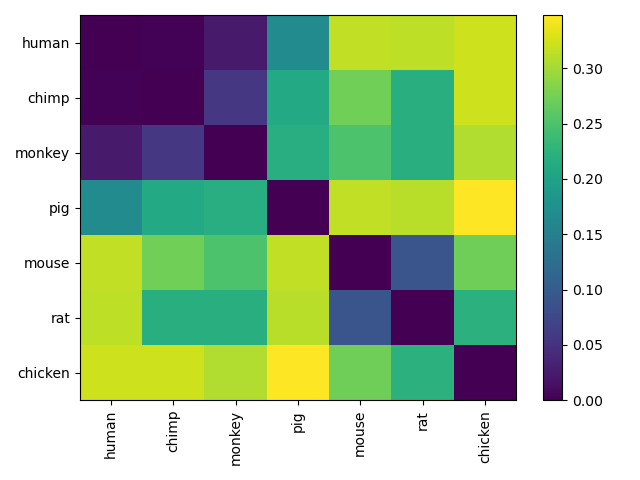

In [38]:
dm = DistanceMatrix.from_iterable(sequences, align_dist, key='id', validate=False)
dm

In [39]:
tree = nj(dm).root_at_midpoint()
print(tree.ascii_art())

                    /-chicken
          /--------|
         |         |          /-rat
         |          \--------|
-root----|                    \-mouse
         |
         |          /-pig
         |         |
          \--------|                    /-chimp
                   |          /--------|
                    \--------|          \-human
                             |
                              \-monkey


In [40]:
guide_lm = average(dm.condensed_form())
guide_lm

array([[0.00000000e+00, 1.00000000e+00, 2.18340611e-03, 2.00000000e+00],
       [2.00000000e+00, 7.00000000e+00, 3.93116776e-02, 3.00000000e+00],
       [4.00000000e+00, 5.00000000e+00, 9.09961686e-02, 2.00000000e+00],
       [3.00000000e+00, 8.00000000e+00, 1.98602208e-01, 4.00000000e+00],
       [6.00000000e+00, 9.00000000e+00, 2.46825397e-01, 3.00000000e+00],
       [1.00000000e+01, 1.10000000e+01, 2.92714375e-01, 7.00000000e+00]])

In [41]:
guide_tree = TreeNode.from_linkage_matrix(guide_lm, dm.ids)
guide_tree

<TreeNode, name: unnamed, internal node count: 5, tips count: 7>

In [42]:
def progressive_msa(query_seqs, guide_tree, pairwise_aligner=global_pairwise_align_nucleotide):
    c1, c2 = guide_tree.children
    if c1.is_tip():
        c1_aln = query_seqs[c1.name]
    else:
        c1_aln = progressive_msa(query_seqs, c1, pairwise_aligner)

    if c2.is_tip():
        c2_aln = query_seqs[c2.name]
    else:
        c2_aln = progressive_msa(query_seqs, c2, pairwise_aligner)

    return pairwise_aligner(c1_aln, c2_aln)[0]

In [ ]:
msa_new = progressive_msa(sequences_dict, guide_tree)

/home/maton/qlab/skbio/github/scikit-bio/skbio/util/_warning.py:56: DeprecationWarning: make_identity_substitution_matrix is deprecated as of 0.4.0. It has been replaced by the SubstitutionMatrix class. Additional details at https://github.com/scikit-bio/scikit-bio/pull/1913.
  warn(


In [ ]:
msa_new.consensus()

## Multiple Sequence Alignment (GOOD)

In [22]:
# using the sequences fomr il6.prot.aln because when I try to use skbio's translate
# from the raw sequences the MSA does not give good results

In [23]:
# set file path
align_path = 'il6.prot.aln'

In [24]:
# read alignment file into TabularMSA
msa = TabularMSA.read(align_path, constructor=Protein)

In [25]:
names = ('human', 'chimp', 'monkey', 'pig', 'mouse', 'rat', 'chicken')
names

('human', 'chimp', 'monkey', 'pig', 'mouse', 'rat', 'chicken')

In [26]:
msa

TabularMSA[Protein]
-----------------------------------------------------------------------
Stats:
    sequence count: 7
    position count: 246
-----------------------------------------------------------------------
MNS------------------FSTSAFGPVAF- ... DMTTHLILRSFKEFLQSSLRALRQM--------
MNS------------------VSTSAFGPVAF- ... DMTTHLILRSFKEFLQSSLRALRQM--------
...
MKF------------------LSARDFQPVAF- ... TKTIQLILKALEEFLKVTMRSTRQT--------
MNFTEGCEATGRRPGSAGSRRRRAPRPGPVALL ... KITMHLILRDFTSFMEKTVRAVRYLKKTRSFSA

In [27]:
# strip gap characters from sequences and get list of AA sequences
prot_seqs = [str(x).replace('-', '') for x in msa]

In [28]:
# make new Protein object with metadata from the gap-stripped sequences
# use these Protein objects for downstream stuff
proteins = [Protein(x, metadata={'id': f'{name}'}) for x, name in zip(prot_seqs, names)]

In [29]:
# need it as dictionary for the way that the progressive alignment is written
proteins_dict = {name: prot for name, prot in zip(names, proteins)}

In [30]:
# check a couple to make sure that the ids match
proteins_dict['mouse']

Protein
---------------------------------------------------------------------
Metadata:
    'id': 'mouse'
Stats:
    length: 211
    has gaps: False
    has degenerates: False
    has definites: True
    has stops: False
---------------------------------------------------------------------
0   MKFLSARDFH PVAFLGLMLV TTTAFPTSQV RRGDFTEDTT PNRPVYTTSQ VGGLITHVLW
60  EIVEMRKELC NGNSDCMNND DALAENNLKL PEIQRNDGCY QTGYNQEICL LKISSGLLEY
120 HSYLEYMKNN LKDNKKDKAR VLQRDTETLI HIFNQEVKDL HKIVLPTPIS NALLTDKLES
180 QKEWLRTKTI QFILKSLEEF LKVTLRSTRQ T

In [31]:
proteins_dict['human']

Protein
---------------------------------------------------------------------
Metadata:
    'id': 'human'
Stats:
    length: 212
    has gaps: False
    has degenerates: False
    has definites: True
    has stops: False
---------------------------------------------------------------------
0   MNSFSTSAFG PVAFSLGLLL VLPAAFPAPV PPGEDSKDVA APHRQPLTSS ERIDKQIRYI
60  LDGISALRKE TCNKSNMCES SKEALAENNL NLPKMAEKDG CFQSGFNEET CLVKIITGLL
120 EFEVYLEYLQ NRFESSEEQA RAVQMSTKVL IQFLQKKAKN LDAITTPDPT TNASLLTKLQ
180 AQNQWLQDMT THLILRSFKE FLQSSLRALR QM

In [32]:
# blosum62 = SubstitutionMatrix.by_name('BLOSUM62')
# blosum62

In [33]:
# def align_dist_prot(seq1, seq2):
#     aln, _, _ = local_pairwise_align_ssw(seq1, seq2, substitution_matrix=blosum62)[0]
#     return hamming(aln[0], aln[1])

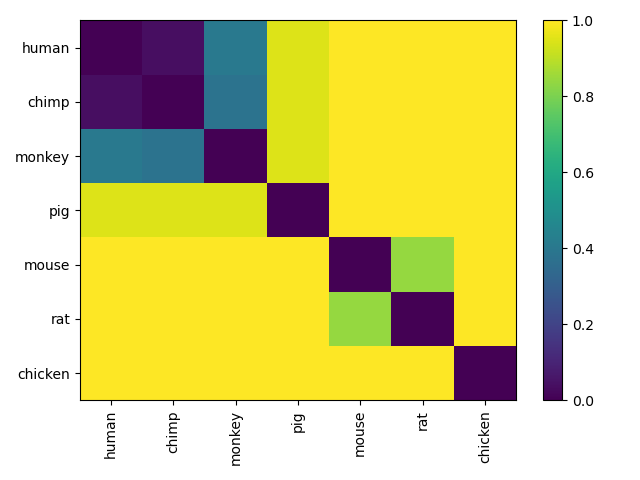

In [34]:
dm = DistanceMatrix.from_iterable(proteins, metric=functools.partial(kmer_distance, k=8), key='id', validate=False)
dm

In [35]:
# guide_lm = average(kmer_distances.condensed_form())
# guid_d = dendrogram(guide_lm, labels=kmer_distances.ids, orientation='right',
#                     link_color_func=lambda x: 'black')

In [36]:
tree = nj(dm).root_at_midpoint()
print(tree.ascii_art())

                    /-chicken
          /--------|
         |         |          /-rat
         |          \--------|
         |                    \-mouse
-root----|
         |                    /-monkey
         |          /--------|
         |         |         |          /-chimp
          \--------|          \--------|
                   |                    \-human
                   |
                    \-pig


In [37]:
guide_lm = average(dm.condensed_form())

In [38]:
guide_tree = TreeNode.from_linkage_matrix(guide_lm, dm.ids)

In [39]:
def progressive_msa(query_seqs, guide_tree, pairwise_aligner=global_pairwise_align_protein):
    c1, c2 = guide_tree.children
    if c1.is_tip():
        c1_aln = query_seqs[c1.name]
    else:
        c1_aln = progressive_msa(query_seqs, c1, pairwise_aligner)

    if c2.is_tip():
        c2_aln = query_seqs[c2.name]
    else:
        c2_aln = progressive_msa(query_seqs, c2, pairwise_aligner)

    return pairwise_aligner(c1_aln, c2_aln)[0]

In [40]:
msa_new = progressive_msa(proteins_dict, guide_tree)

In [41]:
msa_new.reassign_index(minter='id')

In [42]:
msa_new

TabularMSA[Protein]
-----------------------------------------------------------------------
Stats:
    sequence count: 7
    position count: 245
-----------------------------------------------------------------------
MNFTEGCEATGRRPGSAGSRRRRAPRPGPVALL ... KITMHLILRDFTSFMEKTVRAVRYLKKTRSFSA
------------------MKFLSARDFHPVAF- ... TKTIQFILKSLEEFLKVTLRSTRQT--------
...
------------------MNSFSTSAFGPVAF- ... DMTTHLILRSFKEFLQSSLRALRQM--------
------------------MNSVSTSAFGPVAF- ... DMTTHLILRSFKEFLQSSLRALRQM--------

In [43]:
msa_new.consensus()

Protein
---------------------------------------------------------------------
Stats:
    length: 245
    has gaps: True
    has degenerates: False
    has definites: True
    has stops: False
---------------------------------------------------------------------
0   ---------- --------MN SLSTSAFGPV AF---SLGLL LVLAAAFPAP VP---PGEDS
60  KDDAAPHRQP LTSSERIDKL IRYILDGISA LRKETCNKSN MCENSKEALA ENNLNLPKMA
120 EKDGCFQSGF NEETCLVKII TGLLEFEVYL EYLQNRFESS E-EQARAVQM STKVLIQFLQ
180 QKAKNLDAIT TPDPTTNASL LTKLQSQNEW LQDMTIHLIL RSFEEFLQSS LRALRQM---
240 -----

## MSA Exploration
Based on this notebook
https://github.com/scikit-bio/scikit-bio-cookbook/blob/master/Alignments%20and%20phylogenetic%20reconstruction.ipynb

We can next get some information about this alignment. For example, we can easily see that there are 43 sequences in this alignment, and that it's 154 characters long. By definition, there is no variance in sequence length in a multiple sequence alignment. For this reason, it's common to think of an alignment as a matrix or table, where rows represent sequences and columns represent positions in the sequences.

In [44]:
msa_new.shape

Shape(sequence=7, position=245)

In [46]:
msa_new.index

Index(['chicken', 'mouse', 'rat', 'pig', 'monkey', 'human', 'chimp'], dtype='object')

We can also explore some more interesting features of this alignment. For example, we can compute conservation for each position in the alignment using the inverse Shannon uncertainty metric. In this case, we're going to treat gap characters as another character in the amino acid alphabet, though the right way to handle gaps in alignments when computing conservation is debatable. To learn more about positional conservation, see `TabularMSA.conservation`.

In [47]:
positional_conservation = msa_new.conservation(metric='inverse_shannon_uncertainty', degenerate_mode='nan', gap_mode='include')

We get an array of positional conservation values (here we'll just print the first ten). A low conservation value means that there is a lot of variation in the sequences at the corresponding position in the alignment, while a high conservation value means that the corresponding position in the alignment is highly conserved. A conservation of 1.0 means that a position is perfectly conserved. A conservation of 0.0 means that every character in the alphabet is present in exactly equal frequency at that position in the alignment (this is uncommon in practice).

In [48]:
for value in positional_conservation[:10]:
    print(value)

0.8692020172753283
0.8692020172753283
0.8692020172753283
0.8692020172753283
0.8692020172753283
0.8692020172753283
0.8692020172753283
0.8692020172753283
0.8692020172753283
0.8692020172753283


In our alignment, there are exactly 38 positions that are perfectly conserved across all sequences.

In [49]:
(positional_conservation == 1.0).sum()

np.int64(38)

Let's figure out what amino acids are at these perfectly conserved positions:

In [50]:
for pos_idx, conservation in enumerate(positional_conservation):
    if conservation == 1.0:
        aa = msa_new[0][pos_idx]
        print(f"Position {pos_idx} is perfectly conserved, containing {aa} in all sequences.")

Position 28 is perfectly conserved, containing P in all sequences.
Position 29 is perfectly conserved, containing V in all sequences.
Position 30 is perfectly conserved, containing A in all sequences.
Position 36 is perfectly conserved, containing L in all sequences.
Position 38 is perfectly conserved, containing L in all sequences.
Position 40 is perfectly conserved, containing L in all sequences.
Position 45 is perfectly conserved, containing A in all sequences.
Position 47 is perfectly conserved, containing P in all sequences.
Position 93 is perfectly conserved, containing E in all sequences.
Position 95 is perfectly conserved, containing C in all sequences.
Position 101 is perfectly conserved, containing C in all sequences.
Position 108 is perfectly conserved, containing L in all sequences.
Position 111 is perfectly conserved, containing N in all sequences.
Position 112 is perfectly conserved, containing N in all sequences.
Position 113 is perfectly conserved, containing L in all s

Finally we can visualize the conservation along the full length of the alignment to get an idea of where the more and less conserved positions are found. In general, positions that are highly conserved are thought to have specific structural or functional roles in the protein, while positions that are less conserved might have less specific roles (e.g., providing a filler between two functional domains in the linear protein backbone).

Text(0.5, 1.0, 'Positional Conservation Plot')

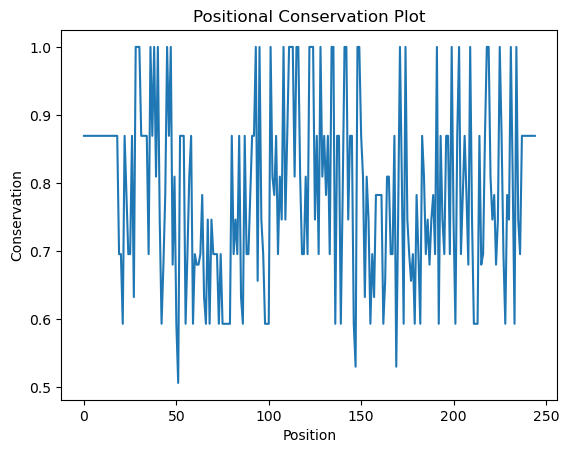

In [60]:
fig, ax = plt.subplots()
ax.plot(range(len(positional_conservation)), positional_conservation)
ax.set_xlabel('Position')
ax.set_ylabel('Conservation')
ax.set_title('Positional Conservation Plot')

## MSA Vizualization
Based on this notebook:
https://github.com/scikit-bio/scikit-bio-cookbook/blob/master/Alignment%20viewing%20and%20filtering.ipynb

In [64]:
hydrophobicity_idx = defaultdict(lambda: np.nan)
hydrophobicity_idx.update({'A': 0.61, 'L': 1.53, 'R': 0.60, 'K': 1.15, 'N': 0.06, 'M': 1.18, 
                           'D': 0.46, 'F': 2.02, 'C': 1.07, 'P': 1.95, 'Q': 0., 'S': 0.05, 
                           'E': 0.47, 'T': 0.05, 'G': 0.07, 'W': 2.65, 'H': 0.61, 'Y': 1.88, 
                           'I': 2.22, 'V': 1.32})
hydrophobicity_labels = ['Hydrophillic', 'Medium', 'Hydrophobic']

In [65]:
msa_new.index

Index(['chicken', 'mouse', 'rat', 'pig', 'monkey', 'human', 'chimp'], dtype='object')

In [69]:
def msa_to_heatmap(msa,
               value_map,
               legend_labels=('Low', 'Medium', 'High'),
               fig_size=(30, 10),
               cmap='YlGn',
               sequence_order=None):
    if sequence_order is None:
        sequence_order = msa.index
            
    # fill a data matrix by iterating over the alignment and mapping
    # characters to values
    mtx = []
    for label in sequence_order:
        seq = str(msa.loc[label])
        mtx.append([value_map[aa] for aa in seq])
        
    # build the heatmap, this code derived from the Matplotlib Gallery
    # http://matplotlib.org/examples/pylab_examples/colorbar_tick_labelling_demo.html
    fig, ax = plt.subplots(dpi=300)
    fig.set_size_inches(fig_size)

    cax = ax.imshow(mtx, interpolation='nearest', cmap=cmap)

    # Add colorbar and define tick labels
    values = list(value_map.values())
    # cbar = fig.colorbar(cax, 
    #                     ticks=[min(values), 
    #                            np.nanmedian(values),
    #                            max(values)],
    #                     orientation='horizontal')
    ax.set_yticks([0] + list(range(3, msa.shape.sequence - 3, 3)) + [msa.shape.sequence - 1])
    ax.set_yticklabels(sequence_order)
    ax.set_xticks(range(msa.shape.position))
    ax.set_xticklabels(msa.consensus(), size=7)
    cbar.ax.set_xticklabels(legend_labels) # horizontal colorbar

In [70]:
[0] + list(range(3, msa.shape.sequence - 3, 3)) + [msa.shape.sequence - 1]

[0, 3, 6]

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (7).

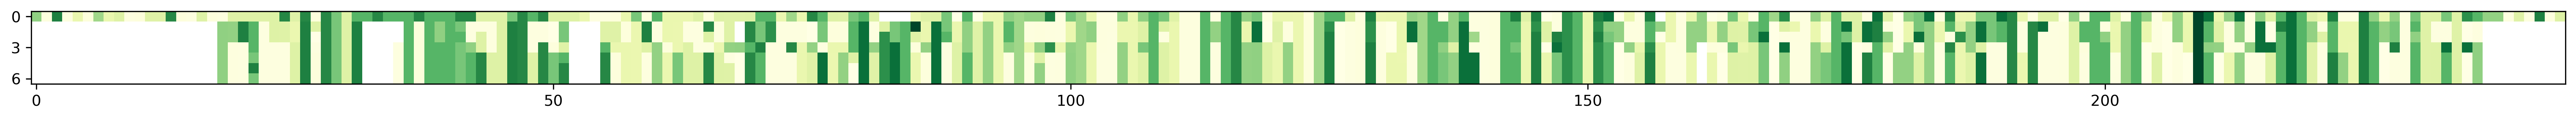

In [71]:
msa_to_heatmap(msa_new, hydrophobicity_idx, legend_labels=hydrophobicity_labels)